In [1]:
import pandas as pd

file_path = 'AGC_Data.csv'

df = pd.read_csv(file_path, parse_dates=["indo_time"], index_col="indo_time")

In [2]:
data_series = df['speed'].values.reshape(-1, 1)

In [3]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data_series)

In [5]:
import numpy as np

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        seq = data[i:(i + seq_length), 0]
        X.append(seq)
        y.append(data[i + seq_length, 0])
    return np.array(X), np.array(y)

In [6]:
seq_length = 60

X_scaled, y_scaled = create_sequences(scaled_data, seq_length)

X_scaled = np.reshape(X_scaled, (X_scaled.shape[0], X_scaled.shape[1], 1))

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(seq_length, 1)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))

In [10]:
model.compile(optimizer='adam', loss='mse')

In [11]:
history = model.fit(X_scaled, y_scaled, epochs=1, batch_size=1, verbose=1)

99940/99940 ━━━━━━━━━━━━━━━━━━━━ 2683s 27ms/step - loss: 0.0014


In [12]:
from sklearn.metrics import classification_report, confusion_matrix
predicted_scaled = model.predict(X_scaled)

predicted = scaler.inverse_transform(predicted_scaled)
actual = scaler.inverse_transform(y_scaled.reshape(-1, 1))

mae = np.mean(np.abs(predicted - actual), axis=1)

df_results = df.iloc[seq_length:].copy()
df_results['mae'] = mae

y_true = df_results['arrival']

normal_maes = df_results[df_results['arrival'] == 0]['mae']
threshold = np.percentile(normal_maes, 95)
print(f"\nCalculated Anomaly Threshold (95th percentile of normal MAE): {threshold:.2f}")

3124/3124 ━━━━━━━━━━━━━━━━━━━━ 54s 17ms/step

Calculated Anomaly Threshold (95th percentile of normal MAE): 175.52


In [13]:
df_results['lstm_pred'] = (df_results['mae'] > threshold).astype(int)

print("\nEvaluation Metrics for LSTM-based Anomaly Detection:")
print("Classification Report:")
print(classification_report(y_true, df_results['lstm_pred']))


Evaluation Metrics for LSTM-based Anomaly Detection:
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97     99465
           1       0.07      0.81      0.13       475

    accuracy                           0.95     99940
   macro avg       0.54      0.88      0.55     99940
weighted avg       0.99      0.95      0.97     99940



![precision_recall](precision_recall.webp)

In [14]:
print("Confusion Matrix:")
print(confusion_matrix(y_true, df_results['lstm_pred']))

Confusion Matrix:
[[94491  4974]
 [   90   385]]


In [15]:
print("\nDataFrame with MAE and LSTM Predictions:")
print(df_results[['speed', 'arrival', 'mae', 'lstm_pred']])


DataFrame with MAE and LSTM Predictions:
                           speed  arrival         mae  lstm_pred
indo_time                                                       
2024-09-06 08:31:41+07:00  62498        0   58.828125          0
2024-09-06 08:31:42+07:00  62845        0   20.957031          0
2024-09-06 08:31:43+07:00  62621        0   72.761719          0
2024-09-06 08:31:44+07:00  62643        0  123.257813          0
2024-09-06 08:31:45+07:00  62482        0  140.261719          0
...                          ...      ...         ...        ...
2024-09-14 23:15:31+07:00  62983        0   52.332031          0
2024-09-14 23:15:32+07:00  63098        0   17.082031          0
2024-09-14 23:15:33+07:00  62989        0   43.535156          0
2024-09-14 23:15:34+07:00  63162        0   58.652344          0
2024-09-14 23:15:35+07:00  63134        0  197.957031          1

[99940 rows x 4 columns]


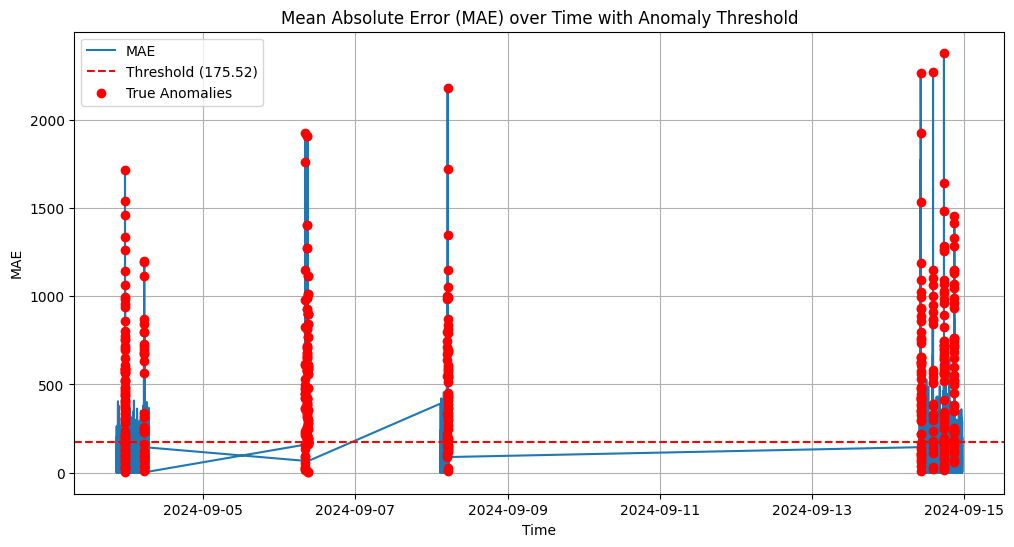

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df_results.index, df_results['mae'], label='MAE')
plt.axhline(y=threshold, color='r', linestyle='--', label=f'Threshold ({threshold:.2f})')
true_anomalies = df_results[df_results['arrival'] == 1]
plt.scatter(true_anomalies.index, true_anomalies['mae'], color='red', label='True Anomalies', zorder=5)
plt.title('Mean Absolute Error (MAE) over Time with Anomaly Threshold')
plt.xlabel('Time')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.show()